### Entrenaiento de modelos de clasificación

In [94]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn import metrics, svm
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.preprocessing import normalize
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

### Procesamiento de datos

In [2]:
# Cargar datos (señales crudas de EMG) en archivo convertido de xls a csv

data = pd.read_csv("Lectura 10.xls.csv")

C:\Users\pedro\AppData\Local\Temp\ipykernel_6096\4150348586.py:3: DtypeWarning: Columns (0,1,2,3,4) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("Lectura 10.xls.csv")


In [3]:
data_to_process = data[["Time", "Raw Ch 1"]]
data_to_process.head()

,Time,Raw Ch 1
0,0,0
1,0.01,0
2,0.02,0
3,0.03,0
4,0.04,0


In [4]:
data_to_process = data_to_process.copy()

# Identificar los índices donde 'Time' cambia de 0 a otro valor para separar segmentos de señales de EMG
cambios_indices = data_to_process[(data_to_process['Time'].shift(1) == "0") & (data_to_process['Time'] != "0")].index
segmento_numero = 0

# Asignar un identificador único a cada segmento
for idx in cambios_indices:
    segmento_numero += 1
    data_to_process.loc[idx:, 'segmento'] = segmento_numero

# Cambiar la columna 'Raw Ch 1' a valores float
data_to_process['Raw Ch 1'] = pd.to_numeric(data_to_process['Raw Ch 1'], errors='coerce')
print(data_to_process)

          Time  Raw Ch 1  segmento
0            0   0.00000       NaN
1         0.01   0.00000       1.0
2         0.02   0.00000       1.0
3         0.03   0.00000       1.0
4         0.04   0.00000       1.0
...        ...       ...       ...
140526  140.14   2.73355      10.0
140527  140.15   1.72041      10.0
140528  140.16   1.35704      10.0
140529  140.17   2.66697      10.0
140530  140.18   2.91512      10.0

[140531 rows x 3 columns]


In [5]:
# Se generan 10 segmentos de señal
data_to_process["Raw Ch 1"][0]

0.0

In [6]:
primer_segmento = data_to_process[data_to_process['segmento'] == 1]
segundo_segmento = data_to_process[data_to_process['segmento'] == 2]
tercero_segmento = data_to_process[data_to_process['segmento'] == 3]
cuarto_segmento = data_to_process[data_to_process['segmento'] == 4]
quinto_segmento = data_to_process[data_to_process['segmento'] == 5]
sexto_segmento = data_to_process[data_to_process['segmento'] == 6]
septimo_segmento = data_to_process[data_to_process['segmento'] == 7]
octavo_segmento = data_to_process[data_to_process['segmento'] == 8]
noveno_segmento = data_to_process[data_to_process['segmento'] == 9]
decimo_segmento = data_to_process[data_to_process['segmento'] == 10]

In [7]:
primer_segmento

,Time,Raw Ch 1,segmento
1,0.01,0.000000,1.0
2,0.02,0.000000,1.0
3,0.03,0.000000,1.0
4,0.04,0.000000,1.0
5,0.05,0.000000,1.0
...,...,...,...
14065,140.65,0.003821,1.0
14066,140.66,0.092823,1.0
14067,140.67,-0.035581,1.0
14068,Time,NaN,1.0


In [8]:
# Función para procesar el segmento y extraer letras

def procesar_segmento(segmento):
    # Verificar que el segmento no esté vacío
    if segmento.empty:
        return segmento

    # Dividir el segmento en 28 partes
    num_partes = 28
    partes = np.array_split(segmento, num_partes)

    # Crear la lista de letras
    letras = [np.nan] + list("ABCDEFGHIJKLMNÑOPQRSTUVWXYZ")[:num_partes-1]

    # Asignar las letras a cada subsegmento
    for i, parte in enumerate(partes):
        parte['Letra'] = letras[i]

    # Concatenar las partes nuevamente
    segmento_procesado = pd.concat(partes)

    return segmento_procesado

In [ ]:
# procesar cada segmento 
segmentos = [primer_segmento, segundo_segmento, tercero_segmento, cuarto_segmento, quinto_segmento, sexto_segmento,
             septimo_segmento, octavo_segmento, noveno_segmento, decimo_segmento]

segmentos_procesados = []

for segmento in segmentos:
    segmento_procesado = procesar_segmento(segmento)
    segmentos_procesados.append(segmento_procesado)


In [10]:
segmentos_procesados[0]

,Time,Raw Ch 1,segmento,Letra
1,0.01,0.000000,1.0,NaN
2,0.02,0.000000,1.0,NaN
3,0.03,0.000000,1.0,NaN
4,0.04,0.000000,1.0,NaN
5,0.05,0.000000,1.0,NaN
...,...,...,...,...
14065,140.65,0.003821,1.0,Z
14066,140.66,0.092823,1.0,Z
14067,140.67,-0.035581,1.0,Z
14068,Time,NaN,1.0,Z


In [40]:
lista_segmentos = []

for df in segmentos_procesados:
    # Lista para almacenar los segmentos de cada letra en el dataframe actual
    segmentos_df = []
    df['Movimiento'] = 0
    # Agregar 1 si la letra requiere movimiento en el gesto de la seña
    df.loc[df['Letra'].isin(['J', 'K', 'Ñ', 'Z']), 'Movimiento'] = 1

    # Filtrar el dataframe por cada letra en la columna 'Letra'
    for letra in "ABCDEFGHIJKLMNÑOPQRSTUVWXYZ":
        segmento = df[df['Letra'] == letra]

        # Agregar el segmento a la lista de segmentos_df
        segmentos_df.append(segmento)

    # Agregar la lista de segmentos_df a la lista principal
    lista_segmentos.append(segmentos_df)
print(lista_segmentos)

[[       Time  Raw Ch 1  segmento Letra  Movimiento
504    5.04  0.625271       1.0     A           0
505    5.05  0.547467       1.0     A           0
506    5.06  0.528856       1.0     A           0
507    5.07  0.549238       1.0     A           0
508    5.08  0.332571       1.0     A           0
...     ...       ...       ...   ...         ...
1002  10.02 -0.046388       1.0     A           0
1003  10.03 -0.187094       1.0     A           0
1004  10.04 -0.057327       1.0     A           0
1005  10.05 -0.123439       1.0     A           0
1006  10.06 -0.115142       1.0     A           0

[503 rows x 5 columns],        Time  Raw Ch 1  segmento Letra  Movimiento
1007  10.07 -0.023725       1.0     B           0
1008  10.08 -0.144260       1.0     B           0
1009  10.09 -0.007929       1.0     B           0
1010   10.1 -0.042932       1.0     B           0
1011  10.11  0.036971       1.0     B           0
...     ...       ...       ...   ...         ...
1505  15.05 -0.217274  

In [41]:

letras_segmentos = {letra: [] for letra in "ABCDEFGHIJKLMNÑOPQRSTUVWXYZ"}

for df in segmentos_procesados:
    # Filtrar el dataframe por cada letra en la columna 'Letra'
    for letra in "ABCDEFGHIJKLMNÑOPQRSTUVWXYZ":
        segmento = df[df['Letra'] == letra]

        # Agregar el segmento a la lista correspondiente en letras_segmentos
        letras_segmentos[letra].append(segmento)

# Imprimir las listas de segmentos organizadas por letra
for letra, segmentos_lista in letras_segmentos.items():
    print(f"{letra} = {segmentos_lista}")

A = [       Time  Raw Ch 1  segmento Letra  Movimiento
504    5.04  0.625271       1.0     A           0
505    5.05  0.547467       1.0     A           0
506    5.06  0.528856       1.0     A           0
507    5.07  0.549238       1.0     A           0
508    5.08  0.332571       1.0     A           0
...     ...       ...       ...   ...         ...
1002  10.02 -0.046388       1.0     A           0
1003  10.03 -0.187094       1.0     A           0
1004  10.04 -0.057327       1.0     A           0
1005  10.05 -0.123439       1.0     A           0
1006  10.06 -0.115142       1.0     A           0

[503 rows x 5 columns],         Time  Raw Ch 1  segmento Letra  Movimiento
14572   5.03 -0.172784       2.0     A           0
14573   5.04  0.763716       2.0     A           0
14574   5.05  0.532330       2.0     A           0
14575   5.06  0.030871       2.0     A           0
14576   5.07 -0.702110       2.0     A           0
...      ...       ...       ...   ...         ...
15069     10 

### Generación de datos (Aumento de datos)

In [72]:
arrays_por_letra = {letra: [] for letra in "ABCDEFGHIJKLMNÑOPQRSTUVWXYZ"}
etiquetas = []

array_sintetico = []
array_etiquetas_sintetico = []
# Función para generar variaciones sintéticas
def generar_variaciones(datos_originales, variacion_min, variacion_max):
    variacion = np.random.uniform(variacion_min, variacion_max, size=datos_originales.shape)
    return datos_originales + variacion

# Itera sobre cada letra
for letra, segmentos_lista in letras_segmentos.items():
    # Itera sobre cada dataframe
    for i, df_segmento in enumerate(segmentos_lista):
        # Crea un DataFrame con la columna Raw Ch 1
        df_letra = pd.DataFrame(df_segmento['Raw Ch 1'].to_numpy()[:500])
        df_movimiento = pd.DataFrame(df_segmento['Movimiento'].to_numpy()[:500])

        # Llena NaN si es necesario
        df_letra = df_letra.reindex(range(500)).fillna(np.nan)

        # Aplica variaciones sintéticas
        for _ in range(3):
            df_letra_sintetico = pd.DataFrame(generar_variaciones(df_letra.to_numpy(), 0.001, 0.02))

            # Concatena los datos sintéticos con el movimiento
            df_sintetico_con_movimiento = pd.concat([df_letra_sintetico, df_movimiento], axis=1)

            # Almacena el array y la etiqueta
            array_sintetico.append(df_sintetico_con_movimiento)
            array_etiquetas_sintetico.append(letra)

print("Shape del array completo con variaciones sintéticas:", np.array(array_sintetico).shape)
print("Shape de las etiquetas:", np.array(array_etiquetas_sintetico).shape)

Shape del array completo con variaciones sintéticas: (810, 500, 2)
Shape de las etiquetas: (810,)


In [75]:
nueva_forma = (np.array(array_sintetico).shape[0], -1)
array_completo_reshaped = np.array(array_sintetico).reshape(nueva_forma)


etiquetas_sinteticas = np.array(array_etiquetas_sintetico)
# Imprimir la nueva forma
print("Nueva forma del array completo:", array_completo_reshaped.shape, etiquetas_sinteticas.shape)

Nueva forma del array completo: (810, 1000) (810,)


In [83]:
arrays_por_letra = {letra: [] for letra in "ABCDEFGHIJKLMNÑOPQRSTUVWXYZ"}
etiquetas = []

# Itera sobre cada letra
for letra, segmentos_lista in letras_segmentos.items():
    # Itera sobre cada dataframe
    for i, df_segmento in enumerate(segmentos_lista):
        # Crea un DataFrame con la columna Raw Ch 1
        df_letra = pd.DataFrame(df_segmento['Raw Ch 1'].to_numpy()[:500])
        df_movimiento = pd.DataFrame(df_segmento['Movimiento'].to_numpy()[:500])

        # Llena NaN si es necesario
        df_letra = df_letra.reindex(range(500)).fillna(np.nan)
        df_movimiento = df_movimiento.reindex(range(500)).fillna(np.nan)

        join_data = pd.concat([df_letra, df_movimiento])

        # Almacena el array y la etiqueta
        arrays_por_letra[letra].append(join_data)

# Modificar el shape a (1, 500)
for letra in arrays_por_letra:
    for i in range(len(arrays_por_letra[letra])):
        arrays_por_letra[letra][i] = arrays_por_letra[letra][i].T

# Convertir las listas de arrays en un solo array
array_completo = np.concatenate([np.concatenate(arrays_por_letra[letra]) for letra in arrays_por_letra])

# Crear etiquetas con el mismo shape
etiquetas = np.repeat(list(arrays_por_letra.keys()), len(arrays_por_letra["A"]))

# Imprimir shapes
print("Shape del array completo:", array_completo.shape)
print("Shape de las etiquetas:", etiquetas.shape)

Shape del array completo: (270, 1000)
Shape de las etiquetas: (270,)


### Forma final de los datos

In [84]:
array_concatenado = np.concatenate([array_completo, array_completo_reshaped], axis=0)
etiquetas_concatenadas = np.concatenate([etiquetas, etiquetas_sinteticas], axis=0)

# Imprimir la forma del array resultante
print("Forma del array concatenado:", array_concatenado.shape, etiquetas_concatenadas.shape)

Forma del array concatenado: (1080, 1000) (1080,)


In [85]:
array_completo_sin_nan = np.nan_to_num(array_concatenado, nan=0)
array_completo_sin_nan.shape

(1080, 1000)

### Divisón de set de datos (entrenamiento y validación)

In [91]:
X_train, X_test, y_train, y_test = train_test_split(array_completo_sin_nan, etiquetas_concatenadas, test_size=0.2, random_state=42)

# Imprime los shapes de los conjuntos de entrenamiento y prueba
print("Shape de X_train:", X_train.shape)
print("Shape de y_train:", y_train.shape)
print("Shape de X_test:", X_test.shape)
print("Shape de y_test:", y_test.shape)

Shape de X_train: (864, 1000)
Shape de y_train: (864,)
Shape de X_test: (216, 1000)
Shape de y_test: (216,)


### Entrenamiento modelo SVM

In [31]:
svm_model = SVC()

In [92]:
param_grid = {'C': [0.1, 1, 10, 100], 'gamma': [0.01, 0.1, 1, 10], 'kernel': ['linear', 'rbf', 'poly']}
grid_search = GridSearchCV(svm_model, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)
print("Best Parameters: ", grid_search.best_params_)
best_svm_model = grid_search.best_estimator_
y_pred = best_svm_model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Best Parameters:  {'C': 1, 'gamma': 0.01, 'kernel': 'linear'}
Accuracy: 0.7916666666666666
Classification Report:
               precision    recall  f1-score   support

           A       0.82      0.82      0.82        11
           B       0.80      0.67      0.73         6
           C       0.75      0.90      0.82        10
           D       0.86      0.67      0.75         9
           E       0.50      0.75      0.60         4
           F       0.83      0.67      0.74        15
           G       0.86      0.67      0.75         9
           H       0.86      0.67      0.75         9
           I       1.00      0.83      0.91        12
           J       1.00      1.00      1.00         8
           K       1.00      0.60      0.75        10
           L       0.67      0.80      0.73         5
           M       0.80      1.00      0.89         4
           N       0.44      0.80      0.57         5
           O       0.57      0.80      0.67         5
           P       0

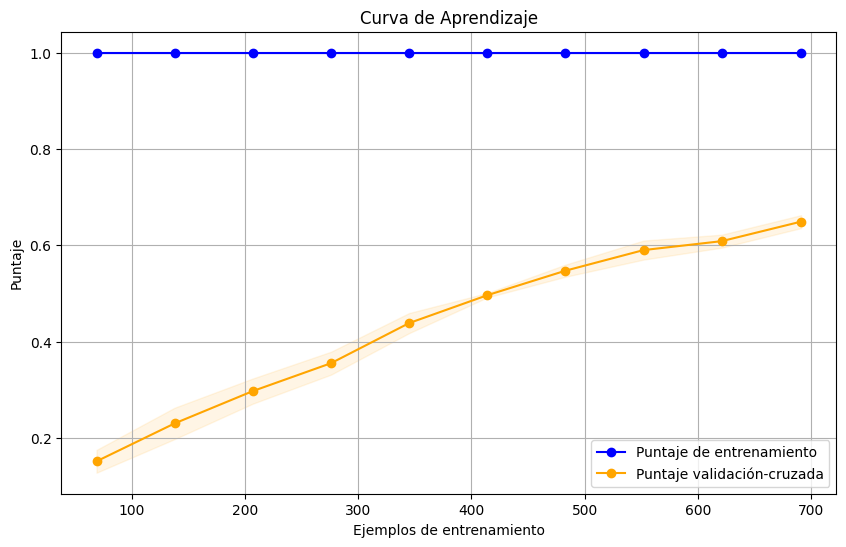

In [99]:
train_sizes, train_scores, validation_scores = learning_curve(best_svm_model, X_train, y_train, cv=5, scoring='accuracy', train_sizes=np.linspace(0.1, 1.0, 10))

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
validation_scores_mean = np.mean(validation_scores, axis=1)
validation_scores_std = np.std(validation_scores, axis=1)

# Trazar las curvas de aprendizaje
plt.figure(figsize=(10, 6))

# Rellena el área entre las curvas de entrenamiento y validación con la desviación estándar
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="blue")
plt.fill_between(train_sizes, validation_scores_mean - validation_scores_std, validation_scores_mean + validation_scores_std, alpha=0.1, color="orange")

# Dibuja las curvas de entrenamiento y validación
plt.plot(train_sizes, train_scores_mean, 'o-', color="blue", label="Puntaje de entrenamiento")
plt.plot(train_sizes, validation_scores_mean, 'o-', color="orange", label="Puntaje validación-cruzada")

# Configura el estilo del gráfico
plt.xlabel("Ejemplos de entrenamiento")
plt.ylabel("Puntaje")
plt.title("Curva de Aprendizaje")
plt.legend(loc="best")
plt.grid(True)  # Agrega una cuadrícula

# Muestra el gráfico
plt.show()

In [89]:
letras = "ABCDEFGHIJKLMNÑOPQRSTUVWXYZ"
lista_letras = list(letras)

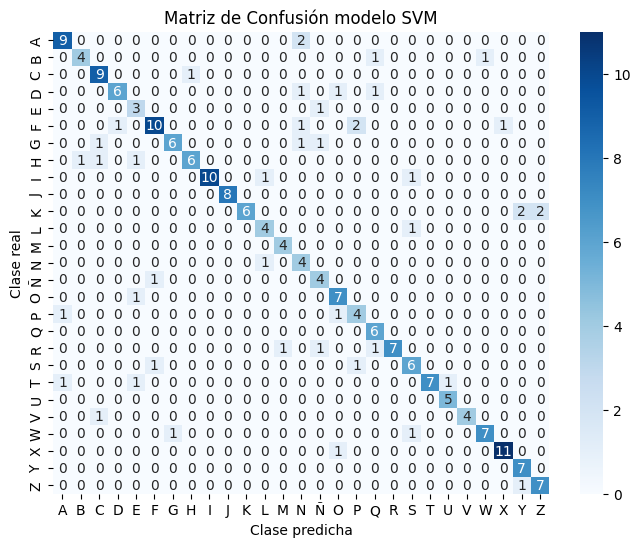

In [108]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=lista_letras, yticklabels=lista_letras)
plt.title('Matriz de Confusión modelo SVM')
plt.xlabel('Clase predicha')
plt.ylabel('Clase real')
plt.show()

In [100]:
import joblib

# Supongamos que ya tienes tu modelo SVM entrenado llamado best_svm_model

# Guardar el modelo en un archivo .h5
joblib.dump(best_svm_model, 'models/pia_svm_clf.h5')

['models/pia_svm_clf.h5']

### Entrenamiento modelo GBM

In [102]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

In [105]:
import lightgbm as lgb

lgb_train = lgb.Dataset(X_train, y_train_encoded)
lgb_test = lgb.Dataset(X_test, y_test_encoded)

params = {
    'task': 'train'
    ,'boosting_type': 'gbdt'
    ,'objective': 'multiclass'
    ,'num_class': 27
    ,'metric': 'multi_logloss'
    }

gbm = lgb.train(params, lgb_train, num_boost_round=150, valid_sets=[lgb_test])
gbm.save_model("models/pia_gbm_clf.txt")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044626 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 139555
[LightGBM] [Info] Number of data points in the train set: 864, number of used features: 1000
[LightGBM] [Info] Start training from score -3.394277
[LightGBM] [Info] Start training from score -3.235212
[LightGBM] [Info] Start training from score -3.360375
[LightGBM] [Info] Start training from score -3.327586
[LightGBM] [Info] Start training from score -3.178054
[LightGBM] [Info] Start training from score -3.542697
[LightGBM] [Info] Start training from score -3.327586
[LightGBM] [Info] Start training from score -3.327586
[LightGBM] [Info] Start training from score -3.429368
[LightGBM] [Info] Start training from score -3.295837
[LightGBM] [Info] Start training from score -3.360375
[LightGBM] [Info] Start training from score -3.206225
[LightGBM] [Info] Start training from score -3.178054
[LightG

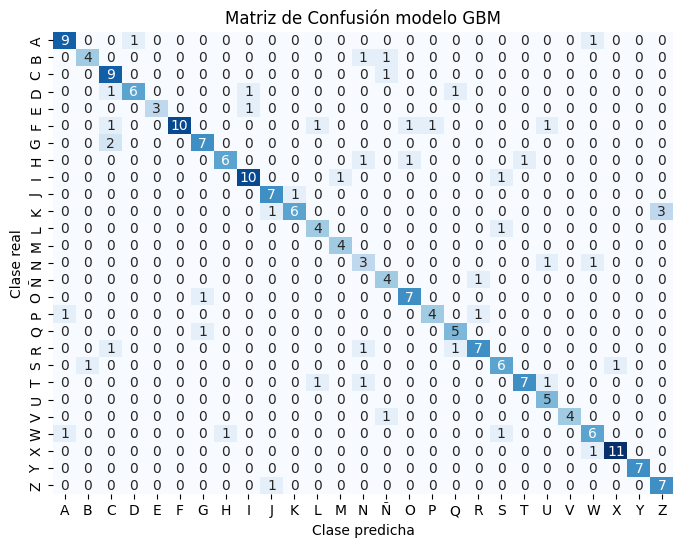

Classification report:
               precision    recall  f1-score   support

           0       0.82      0.82      0.82        11
           1       0.80      0.67      0.73         6
           2       0.64      0.90      0.75        10
           3       0.86      0.67      0.75         9
           4       1.00      0.75      0.86         4
           5       1.00      0.67      0.80        15
           6       0.78      0.78      0.78         9
           7       0.86      0.67      0.75         9
           8       0.83      0.83      0.83        12
           9       0.78      0.88      0.82         8
          10       0.86      0.60      0.71        10
          11       0.67      0.80      0.73         5
          12       0.80      1.00      0.89         4
          13       0.43      0.60      0.50         5
          14       0.57      0.80      0.67         5
          15       0.78      0.88      0.82         8
          16       0.80      0.67      0.73         6
   

In [109]:
model = lgb.Booster(model_file="models/pia_gbm_clf.txt")

predictions = model.predict(X_test)
predicted_classes = np.argmax(predictions, axis=1)

y_test_encoded = label_encoder.transform(y_test)

predicted_letters = [lista_letras[i] for i in predicted_classes]
true_letters = [lista_letras[i] for i in y_test_encoded]

# Crear la matriz de confusión
conf_matrix = confusion_matrix(true_letters, predicted_letters, labels=lista_letras)

# Crear un DataFrame para mostrar la matriz de confusión con cantidades
conf_matrix_df = pd.DataFrame(conf_matrix, index=lista_letras, columns=lista_letras)

# Visualizar la matriz de confusión con cantidades
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_df, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Matriz de Confusión modelo GBM')
plt.xlabel('Clase predicha')
plt.ylabel('Clase real')
plt.show()

# Imprimir el informe de clasificación
print("Classification report:\n", classification_report(y_test_encoded, predicted_classes))